In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


## Load and inspect simulation data

In [2]:
import pandas
import seaborn
from scipy.stats import skew, entropy, kurtosis, gaussian_kde, pearsonr
from os import listdir
from SuchTree import SuchTree, SuchLinkedTrees
from pyprind import ProgBar

reading data, building graphs...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29


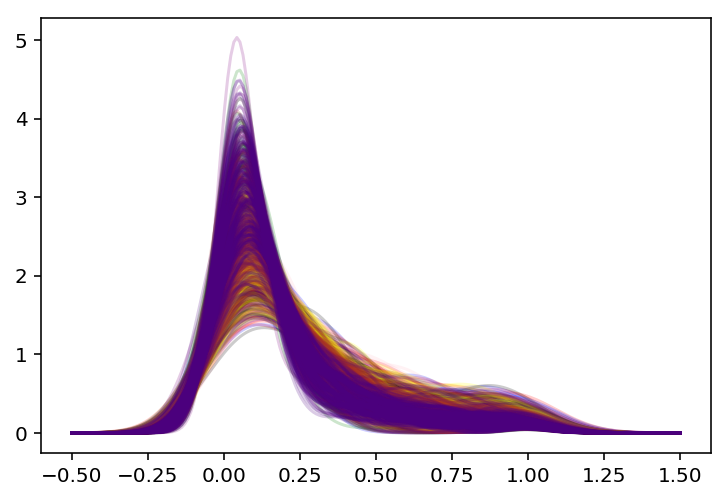

In [3]:
X = linspace( -0.5, 1.5, 200 )

path_noswitch_slow     = { 'path'  : 'simulations/noswitch_slow/',
                           'label' : 'noswitch_slow',
                           'switch': 'none',
                           'g_evol': 'slow',
                           'color' : 'red' }
path_noswitch_balanced = { 'path'  : 'simulations/noswitch_balanced/',
                           'label' : 'noswitch_balanced',
                           'switch': 'none',
                           'g_evol': 'balanced',
                           'color' : 'blue' }
path_noswitch_fast     = { 'path'  : 'simulations/noswitch_fast/',
                           'label' : 'noswitch_fast',
                           'switch': 'none',
                           'g_evol': 'fast',
                           'color' : 'green' }

path_slowswitch_slow     = { 'path'  : 'simulations/slowswitch_slow/',
                             'label' : 'slowswitch_slow',
                             'switch': 'slow',
                             'g_evol': 'slow',
                             'color' : 'pink' }
path_slowswitch_balanced = { 'path'  : 'simulations/slowswitch_balanced/',
                             'label' : 'slowswitch_balanced',
                             'switch': 'slow',
                             'g_evol': 'balanced',
                             'color' : 'black' }
path_slowswitch_fast     = { 'path'  : 'simulations/slowswitch_fast/',
                             'label' : 'slowswitch_fast',
                             'switch': 'slow',
                             'g_evol': 'fast',
                             'color' : 'purple' }

path_fastswitch_slow     = { 'path'  : 'simulations/fastswitch_slow/',
                             'label' : 'fastswitch_slow',
                             'switch': 'fast',
                             'g_evol': 'slow',
                             'color' : 'yellow' }
path_fastswitch_balanced = { 'path'  : 'simulations/fastswitch_balanced/',
                             'label' : 'fastswitch_balanced',
                             'switch': 'fast',
                             'g_evol': 'balanced',
                             'color' : 'brown' }
path_fastswitch_fast     = { 'path'  : 'simulations/fastswitch_fast/',
                             'label' : 'fastswitch_fast',
                             'switch': 'fast',
                             'g_evol': 'fast',
                             'color' : 'indigo' }

allsims = [ path_noswitch_slow,   path_noswitch_balanced,   path_noswitch_fast,
            path_slowswitch_slow, path_slowswitch_balanced, path_slowswitch_fast,
            path_fastswitch_slow, path_fastswitch_balanced, path_fastswitch_fast]

moments = []
data = []
spectra = []
SLTs = []
igraphs = []

p = ProgBar( sum( [ len(i) for i in [ listdir(sim['path']) for sim in allsims ] ] ),
             title='reading data, building graphs...' )

for sim in allsims :
    for run in listdir( sim['path'] ) :
        if run.endswith( '.log' ) : p.update(); continue
        
        sim['run'] = run
        path = sim['path'] + run + '/'
        
        # read the calculated eigenvalues, build density distribution
        eg = array( map( float, open( path + 'eigenvalues.csv').readline().split()[1].split(',') ) )
        density = gaussian_kde( eg/max(eg), bw_method=0.4 ).pdf( X )
        
        # read the calculated moments, build a DataFrame row
        moments.append( pandas.read_csv( path + 'moments.csv' ) )
        d = pandas.read_csv( path + 'data.csv' )
        d = pandas.DataFrame([sim]).join(d)
        data.append( d )
        
        # plot the spectral densities
        spectra.append( density )
        plot( X, density, color=sim['color'], alpha=0.2 )
        
        # build the graph objects
        T1 = SuchTree( path + 'host.relaxed.tree' )
        T2 = SuchTree( path + 'guest.relaxed.tree' )
        LK = pandas.read_csv( path + 'links.csv', index_col=0 )
        SLT = SuchLinkedTrees( T1, T2, LK )
        SLTs.append( SLT )
        igraphs.append( SLT.to_igraph() )
        
        p.update()
    
moments = pandas.concat( moments, ignore_index=True )
data = pandas.concat( data, ignore_index=True )

In [4]:
q = moments.join(data)
q.head()

,eigengap,skew,occupancy,treedist,p,r,squareness,kurtosis,color,g_evol,...,duplication_rate,prefix,guest_leafs,theta,k,loss_rate,min_guest_leafs,host_leafs,max_guest_leafs,max_host_leafs
0,0.008567,1.532039,1.000000,0.090924,1.946461e-15,0.956567,1.000000,0.941858,red,slow,...,0.0125,noswitch_slow/run155,8,0.5,2.0,0.0025,4,8,128,128
1,0.759379,1.667788,1.100000,0.094697,1.424206e-09,0.708606,0.818182,1.452428,red,slow,...,0.0125,noswitch_slow/run170,11,0.5,2.0,0.0025,4,9,128,128
2,0.021587,1.501637,1.111111,0.251921,9.302377e-01,-0.013428,0.800000,0.811985,red,slow,...,0.0125,noswitch_slow/run162,10,0.5,2.0,0.0025,4,8,128,128
3,0.135778,1.175743,1.000000,0.209243,1.218665e-02,0.370688,1.000000,0.040489,red,slow,...,0.0125,noswitch_slow/run14,10,0.5,2.0,0.0025,4,10,128,128
4,0.008143,1.291845,1.052632,0.218949,5.438063e-02,0.288766,0.900000,0.223591,red,slow,...,0.0125,noswitch_slow/run165,10,0.5,2.0,0.0025,4,9,128,128


Text(0.5,0,u'graph density')

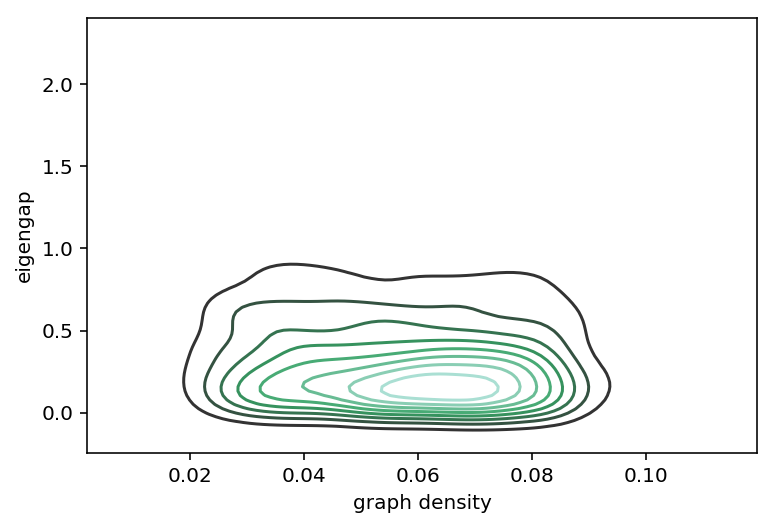

In [5]:
#scatter( q.occupancy, q.treedist )

seaborn.kdeplot( [ ig.density() for ig in igraphs ], q.eigengap )
xlabel( 'graph density' )

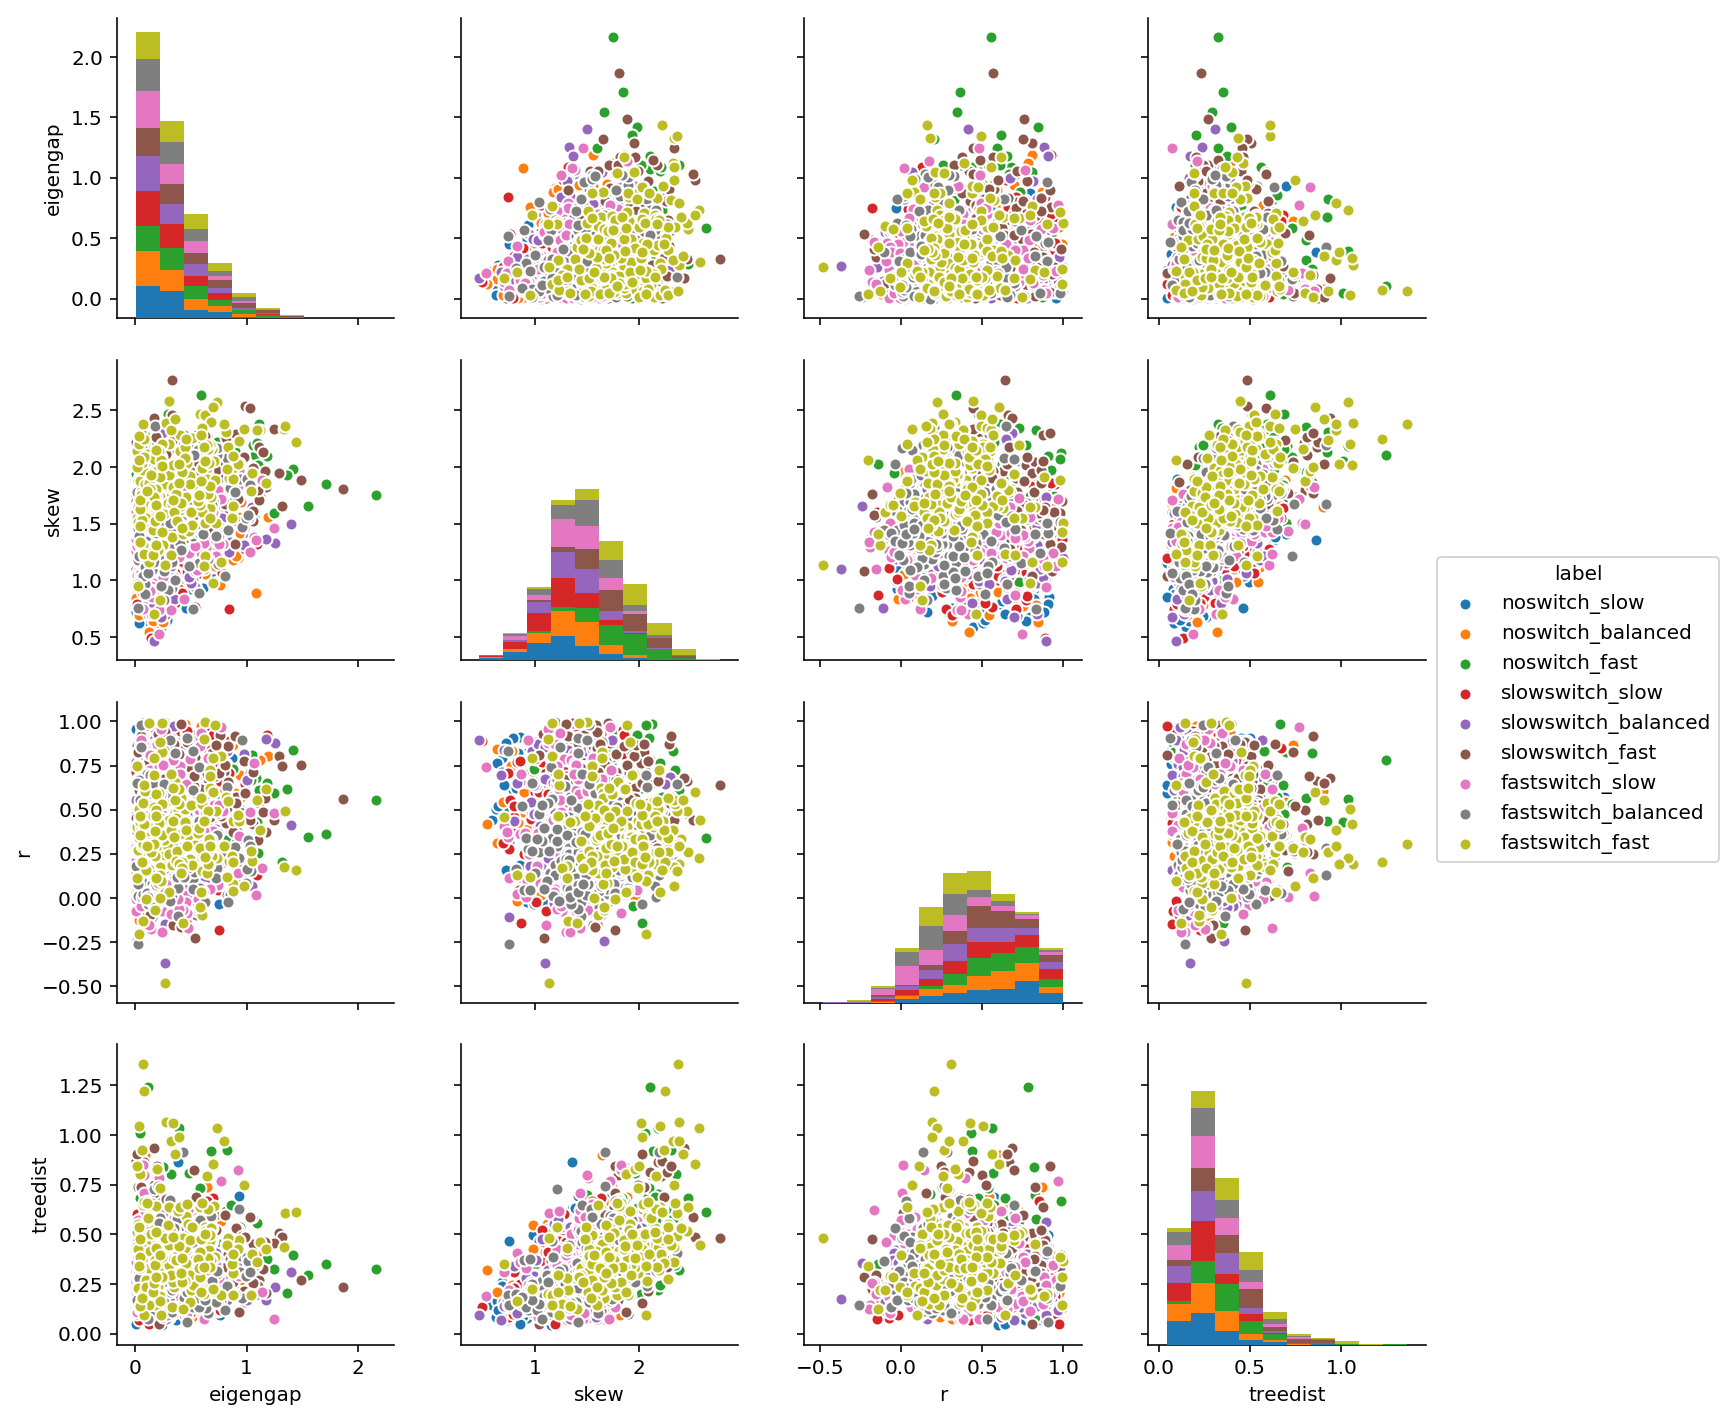

In [6]:
seaborn.pairplot( q.dropna(), vars=['eigengap', 'skew', 'r', 'treedist',], hue='label' )

We expepect that as the spectral distance between the tree components of a graph increases
(indicating more dissimilar tree topology), the Hommola correlation of the interaction graph
should decrease. They are indeed inversely correlated, though not strongly so (r=-0.08, p=0.0008).

(-0.07869711207801401, 0.0008382657292578823)


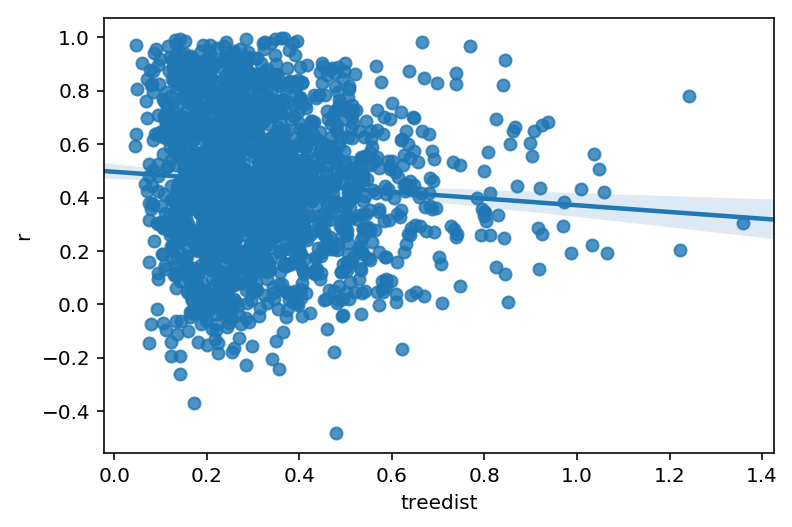

In [7]:
seaborn.regplot( x='treedist', y='r', data=q.dropna() )
print pearsonr( q.dropna().treedist, q.dropna().r ) 

## Clustering with graph moments

In [5]:
# This code is adapted from BiWeb
# https://github.com/tpoisot/bipy/blob/master/bipy/nes/nodf.py

def adjacency(W):
    # from BiWeb 
    adj = numpy.copy(W)
    adj[adj>0] = 1
    return adj

def generality(W):
    # from BiWeb
    ad = adjacency(W)
    gen = numpy.sum(ad,axis=1)
    return gen

def vulnerability(W):
    # from BiWeb
    ad = adjacency(W)
    vul = numpy.sum(ad,axis=0)
    return vul

def v_rank(V):
    # from BiWeb
    # Returns the rank of a vector
    # with no ties
    rn = numpy.zeros(len(V),dtype=numpy.int32)
    crnk = 0
    while crnk < len(V):
        for j in xrange(0,len(V)):
            cMax = numpy.max(V)
            if V[j] == cMax:
                rn[j] = crnk
                crnk += 1
                V[j] = numpy.min(V)-1
                break
    return rn

def sortbydegree(W):
    # from BiWeb
    # Sort a matrix by degree
 
    g = generality(W)
    v = vulnerability(W)
    upsp = len(W)
    losp = len(W[0])
    web = W
    ## Step 1 : sort TLO
    rG = v_rank( g )
    nW = numpy.zeros((upsp,losp))
    for ro in range(0,upsp):
        nW[rG[ro]] = web[ro]
    ## Step 2 : sort BLO
    nW = nW.T
    dW = numpy.zeros((upsp,losp)).T
    rG = v_rank(v)
    for ro in range(0,losp):
        dW[rG[ro]] = nW[ro]
    Fweb = numpy.copy(dW.T)

    return Fweb

def nestadj(aW):
    # from BiWeb
    return adjacency(sortbydegree(aW))

def compareones(w1,w2,tn):
    # from BiWeb
    if tn == 0 : return 0.0
    return numpy.sum( (w1+w2) == 2 )/tn

def getNpaired(W):
    # Required for NODF calculation
    # Get the N paired value of a web
    Npaired = []
    gen = generality(W)
    for i in xrange(0,(len(W)-1)):
        for j in xrange((i+1),len(W)):
            if gen[i] >= gen[j]:
                Npaired.append(compareones(W[i],W[j],gen[j]))
            else :
                Npaired.append(0.0)
    return Npaired

def nodf(aW):
    # from BiWeb
    """
    The strict boolean tells if the condition for overlap needs to be
    strictly enforced or not. If srict = False, this can somehow increase the NODF
    values.
    """
    if (len(aW[0])==1)|(len(aW)==1):
        return [0,0,0]
    W = nestadj(aW)
    NProw = getNpaired(W)
    NPcol = getNpaired(W.T)
    # Output the NODF value
    ColCor = (len(W[0])*(len(W[0])-1))/2.0
    RowCor = (len(W)*(len(W)-1))/2.0
    NrowSum = numpy.sum( NProw )
    NcolSum = numpy.sum( NPcol )
    WholeNest = (NcolSum+NrowSum)/(ColCor + RowCor)
    ColNest = NcolSum/ColCor
    RowNest = NrowSum/RowCor
    return WholeNest, ColNest, RowNest

In [6]:
gm = q[[ 'eigengap', 'skew', 'occupancy', 'treedist', 'r', 'p', 'squareness', 'kurtosis' ]]

gm = gm.join( pandas.DataFrame( [ ig.diameter() for ig in igraphs ], columns=['diameter'] ) )
gm = gm.join( pandas.DataFrame( [ mean(ig.eccentricity()) for ig in igraphs ], columns=['eccentricity'] ) )
gm = gm.join( pandas.DataFrame( [ mean(ig.betweenness()) for ig in igraphs ], columns=['mean_betweenness'] ) )
gm = gm.join( pandas.DataFrame( [ std(ig.betweenness()) for ig in igraphs ], columns=['std_betweenness'] ) )
gm = gm.join( pandas.DataFrame( [ ig.modularity( ig.vs['tree'] ) for ig in igraphs], columns=['modularity'] ) )
#gm = gm.join( pandas.DataFrame( [ nodf( SLT.linkmatrix ) for SLT in SLTs ], columns=['WholeNest', 'ColNest', 'RowNest'] ) )
gm = gm.join( pandas.DataFrame( [ nodf( SLT.linkmatrix )[0] for SLT in SLTs ], columns=['nestedness'] ) )

gm.head()

,eigengap,skew,occupancy,treedist,r,p,squareness,kurtosis,diameter,eccentricity,mean_betweenness,std_betweenness,modularity,nestedness
0,0.008567,1.532039,1.000000,0.090924,0.956567,1.946461e-15,1.000000,0.941858,7,6.600000,45.066667,35.509510,0.277778,0.000000
1,0.759379,1.667788,1.100000,0.094697,0.708606,1.424206e-09,0.818182,1.452428,8,7.210526,62.921053,57.985167,0.262336,0.021978
2,0.021587,1.501637,1.111111,0.251921,-0.013428,9.302377e-01,0.800000,0.811985,8,7.294118,56.176471,47.404261,0.257370,0.027397
3,0.135778,1.175743,1.000000,0.209243,0.370688,1.218665e-02,1.000000,0.040489,9,7.947368,66.736842,60.384053,0.282609,0.000000
4,0.008143,1.291845,1.052632,0.218949,0.288766,5.438063e-02,0.900000,0.223591,9,8.111111,63.694444,54.963393,0.271694,0.012346


In [17]:
from sklearn.manifold import TSNE, MDS, Isomap

gm_embedded = pandas.DataFrame( TSNE(n_components=2, perplexity=100).fit_transform( gm.dropna() ), 
                                columns=['tSNEx','tSNEy'] )
#gm_embedded = pandas.DataFrame( MDS(n_components=2, metric=True ).fit_transform( gm.dropna() ), 
#                                columns=['MDSx','MDSy'] )

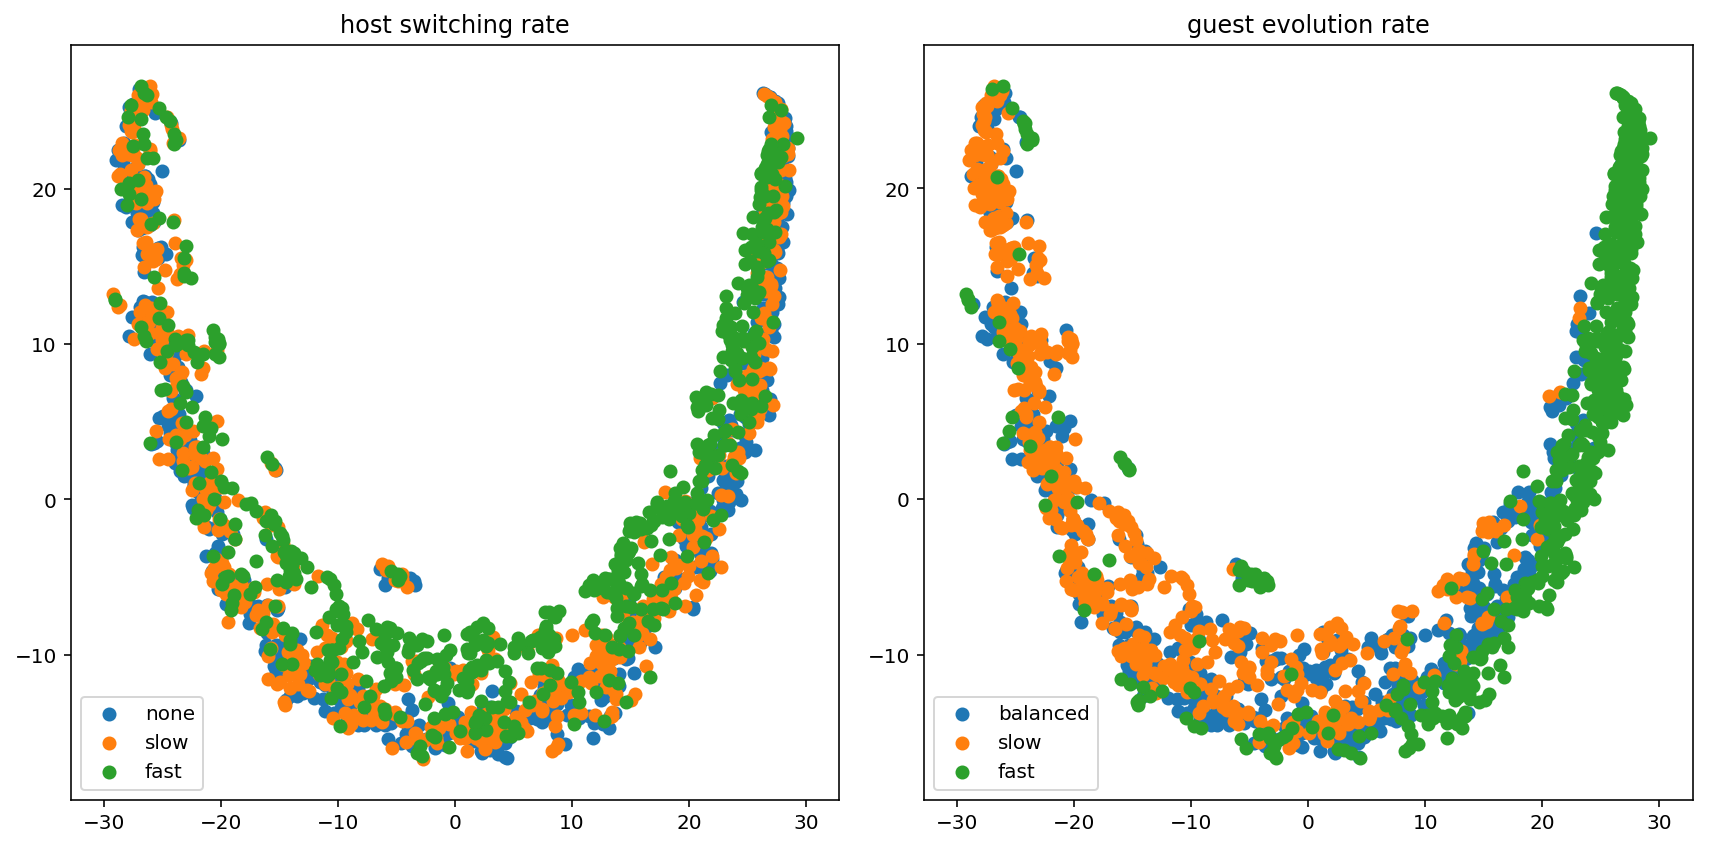

In [20]:
figure( figsize=(12,6) )

qq = q.dropna().join( gm_embedded )

xname,yname = gm_embedded.columns

subplot(1,2,1)
title( 'host switching rate' )
for l in set( qq.switch ) :
    scatter( qq[qq.switch==l][xname], qq[qq.switch==l][yname], label=l )
legend( loc=3 )

subplot(1,2,2)
title( 'guest evolution rate' )
for l in set( qq.g_evol ) :
    scatter( qq[qq.g_evol==l][xname], qq[qq.g_evol==l][yname], label=l )
legend( loc=3 )

tight_layout()

In [21]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = gm.dropna()
y = pandas.get_dummies( q.loc[X.index][['g_evol', 'switch']] )

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)

forest = RandomForestClassifier( n_estimators=1000,
                                 criterion='entropy',
                                 random_state=0,
                                 n_jobs=4 )

forest.fit( X_train, y_train )
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print( 'Feature ranking :' )
for f in range(X.shape[1]):
    print( '%d. feature %d : %f (%s)' % ( f + 1,
                                          indices[f],
                                          importances[indices[f]],
                                          X.columns[indices[f]] ) )

print( 'Score : %f' % ( forest.score( X_test, y_test ) ) )

Feature ranking :
1. feature 13 : 0.144939 (nestedness)
2. feature 11 : 0.110407 (std_betweenness)
3. feature 4 : 0.096070 (r)
4. feature 10 : 0.072495 (mean_betweenness)
5. feature 7 : 0.067759 (kurtosis)
6. feature 9 : 0.066786 (eccentricity)
7. feature 1 : 0.064979 (skew)
8. feature 0 : 0.064078 (eigengap)
9. feature 3 : 0.063367 (treedist)
10. feature 12 : 0.057864 (modularity)
11. feature 6 : 0.056611 (squareness)
12. feature 2 : 0.056249 (occupancy)
13. feature 5 : 0.054830 (p)
14. feature 8 : 0.023566 (diameter)
Score : 0.244444


Text(0,0.5,u'feature importance')

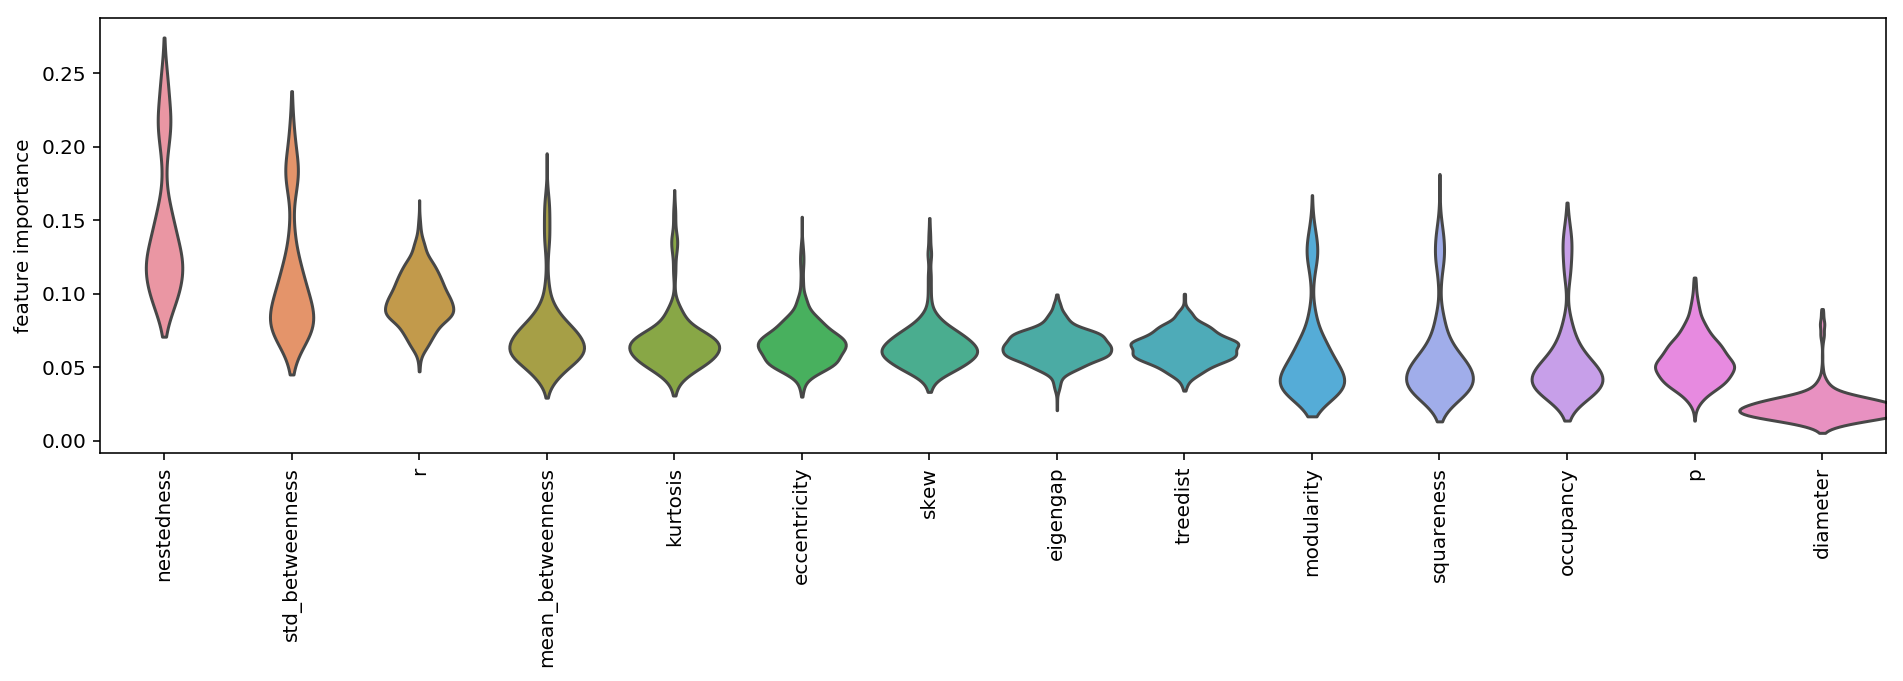

In [22]:
forest_imp = pandas.DataFrame( array( [tree.feature_importances_ for tree in forest.estimators_] ),
                               columns=X.columns)

figure( figsize=(16,4) )
seaborn.violinplot( x='variable',
                    y='value',
                    data=forest_imp.melt(),
                    order=X.columns[indices],
                    width=1.3, cut=0.001, inner=None )
xticks(range(X.shape[1]), rotation='vertical')
xlabel('')
ylabel('feature importance')

## Clustering with spectral distances

In [23]:
from pyprind import ProgBar

p = ProgBar( len(spectra)**2, title='calculating spectral distances...' )

s_d = zeros( ( len( spectra ), len( spectra ) ) )
for i in range( s_d.shape[0] ) :
    for j in range( s_d.shape[1] ) :
        p.update()
        s_d[i,j] = sqrt( 0.5 * ( entropy( spectra[i], spectra[j] ) + entropy( spectra[j], spectra[i] ) ) )

calculating spectral distances...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:05:05


/home/russell/opt/local/lib/python2.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


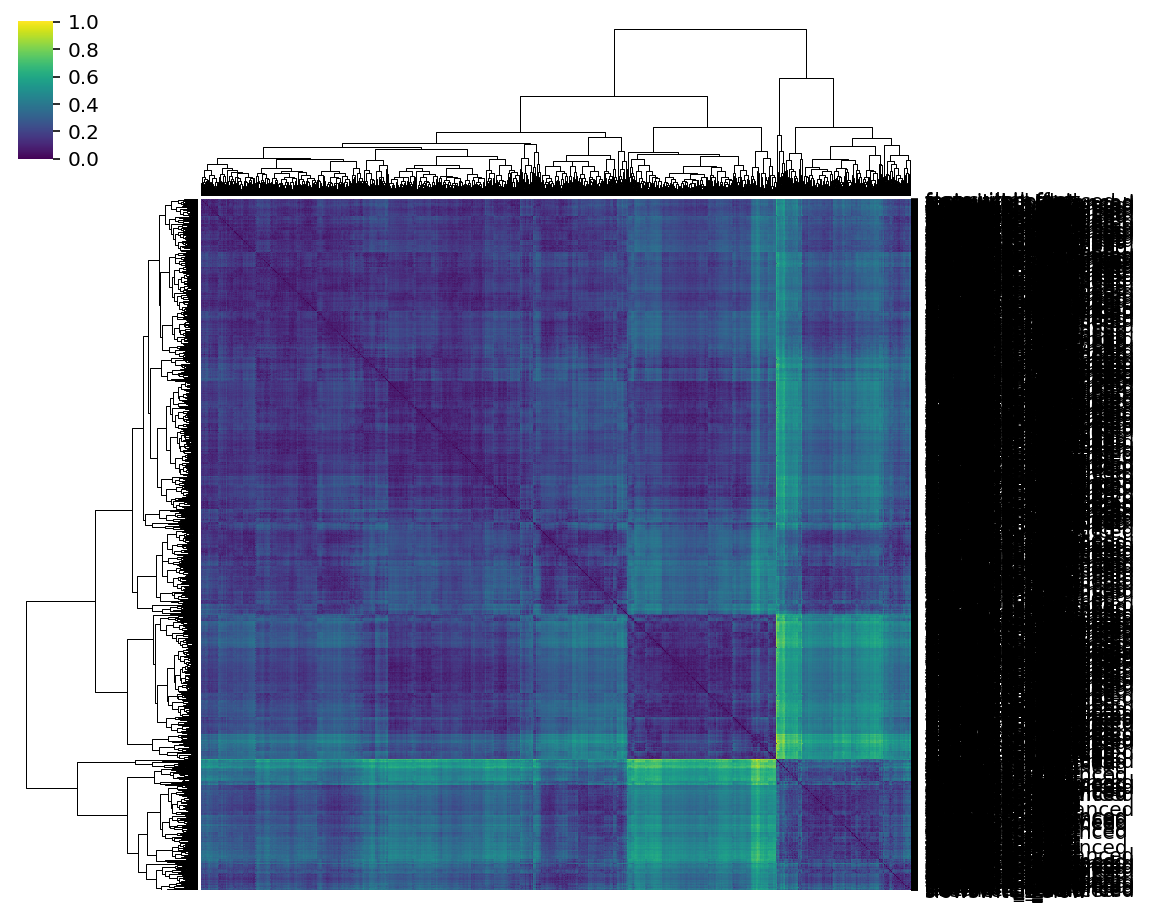

In [24]:
seaborn.clustermap( s_d, cmap='viridis', method='weighted', metric='euclidean', #metric='correlation',
                    figsize=(8,8), xticklabels=False, yticklabels=q.label )

In [25]:
from sklearn.manifold import TSNE, MDS, Isomap

sd_embedded = pandas.DataFrame( TSNE(n_components=2, perplexity=300).fit_transform( s_d ), 
                                columns=['tSNEx','tSNEy'] )
#sd_embedded = pandas.DataFrame( MDS(n_components=2, metric=True ).fit_transform( s_d ), 
#                                columns=['MDSx','MDSy'] )
#sd_embedded = pandas.DataFrame( Isomap(n_components=2 ).fit_transform( s_d ), 
#                                columns=['Isox','Isoy'] )

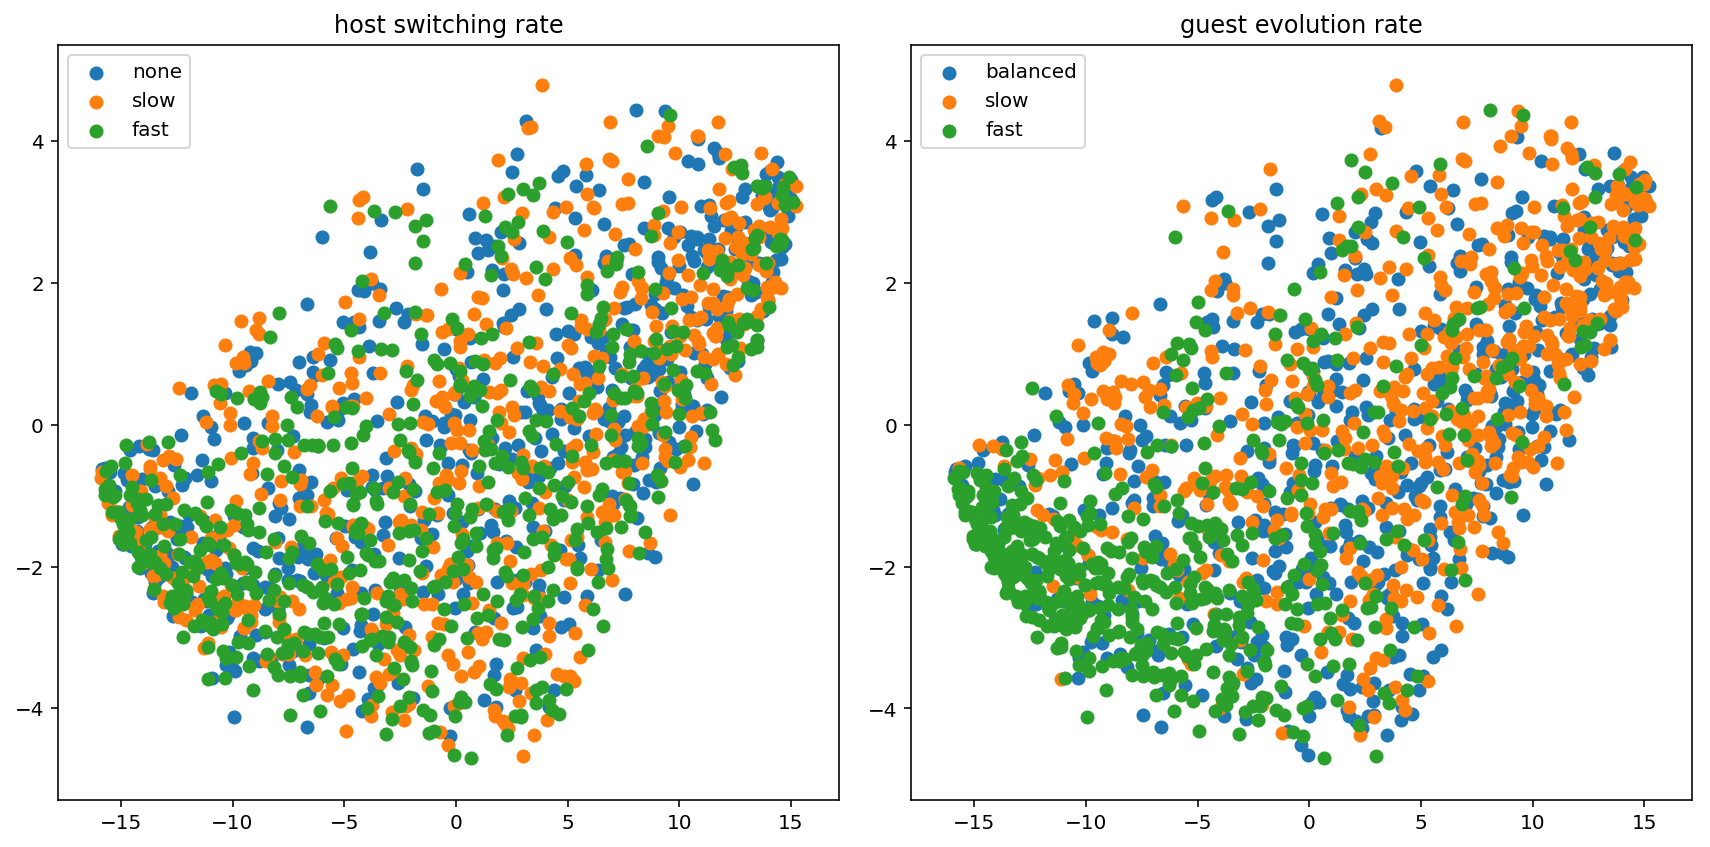

In [26]:
figure( figsize=(12,6) )

qq = q.join( sd_embedded )

subplot(1,2,1)
title( 'host switching rate' )
for l in set( qq.switch ) :
    scatter( qq[qq.switch==l]['tSNEx'], qq[qq.switch==l]['tSNEy'], label=l )
#legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=3, mode="expand", borderaxespad=0. )
legend( loc=2 )

subplot(1,2,2)
title( 'guest evolution rate' )
for l in set( qq.g_evol ) :
    scatter( qq[qq.g_evol==l]['tSNEx'], qq[qq.g_evol==l]['tSNEy'], label=l )
#legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=3, mode="expand", borderaxespad=0. )
legend( loc=2 )

tight_layout()

In [30]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#X = pandas.get_dummies( q[['g_evol', 'switch']] )
X = pandas.get_dummies( q[['label']] )
#y = pandas.DataFrame( g, index=q.index, columns=q.index )
y = s_d

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)


#forest = RandomForestClassifier( n_estimators=100,
#                                 criterion='entropy',
#                                 random_state=0,
#                                 n_jobs=4 )

forest = RandomForestRegressor( n_estimators=200,
                                #criterion='gini',
                                random_state=0,
                                n_jobs=4 )


forest.fit( X_train, y_train )
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print( 'Feature ranking :' )
for f in range(X.shape[1]):
    print( '%d. feature %d : %f (%s)' % ( f + 1,
                                          indices[f],
                                          importances[indices[f]],
                                          X.columns[indices[f]] ) )
    
print( 'Score : %f' % ( forest.score( X_test, y_test ) ) )

Feature ranking :
1. feature 1 : 0.324553 (label_fastswitch_fast)
2. feature 4 : 0.284375 (label_noswitch_fast)
3. feature 7 : 0.255541 (label_slowswitch_fast)
4. feature 0 : 0.064787 (label_fastswitch_balanced)
5. feature 5 : 0.020866 (label_noswitch_slow)
6. feature 2 : 0.018255 (label_fastswitch_slow)
7. feature 8 : 0.015491 (label_slowswitch_slow)
8. feature 6 : 0.008941 (label_slowswitch_balanced)
9. feature 3 : 0.007191 (label_noswitch_balanced)
Score : 0.173134


Text(0,0.5,u'feature importance')

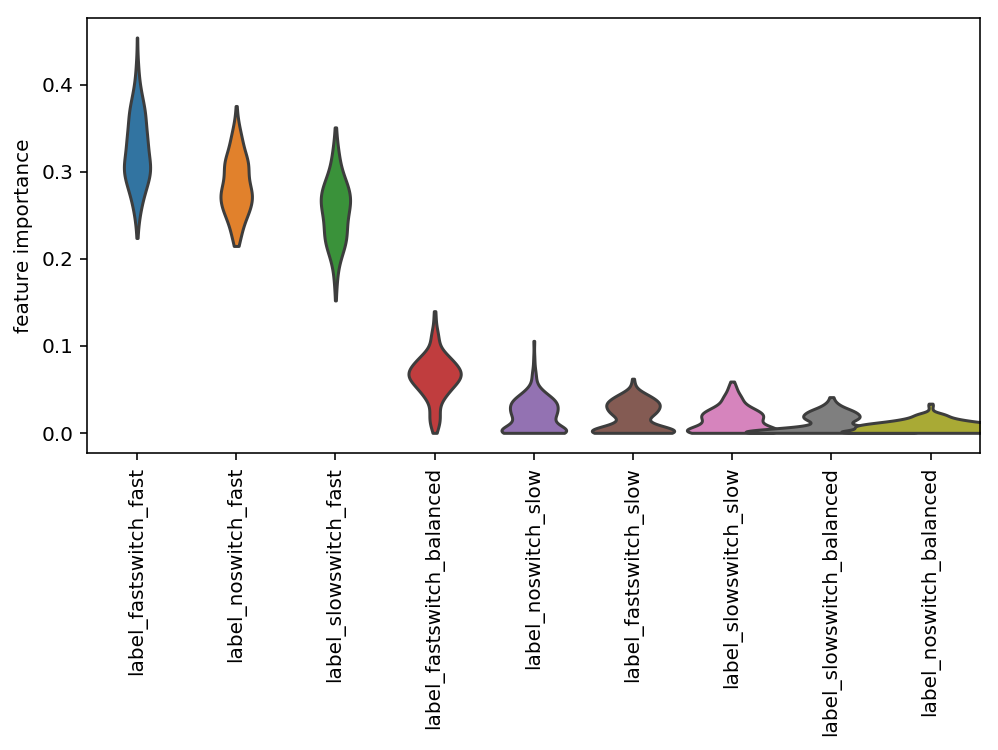

In [31]:
forest_imp = pandas.DataFrame( array( [tree.feature_importances_ for tree in forest.estimators_] ),
                               columns=X.columns)

figure( figsize=(8,4) )
seaborn.violinplot( x='variable',
                    y='value',
                    data=forest_imp.melt(),
                    order=X.columns[indices],
                    width=1.8, cut=0.001, inner=None )
xticks(range(X.shape[1]), rotation='vertical')
xlabel('')
ylabel('feature importance')

## Clustering with graph kernels

In [36]:
import graphkernels.kernels as gk

g = gk.CalculateConnectedGraphletKernel( igraphs )
#g = gk.CalculateEdgeHistGaussKernel( igraphs ) # nope
#g = gk.CalculateWLKernel( igraphs )
#g = gk.CalculateGraphletKernel( igraphs )
#g = gk.CalculateKStepRandomWalkKernel( igraphs ) # too big

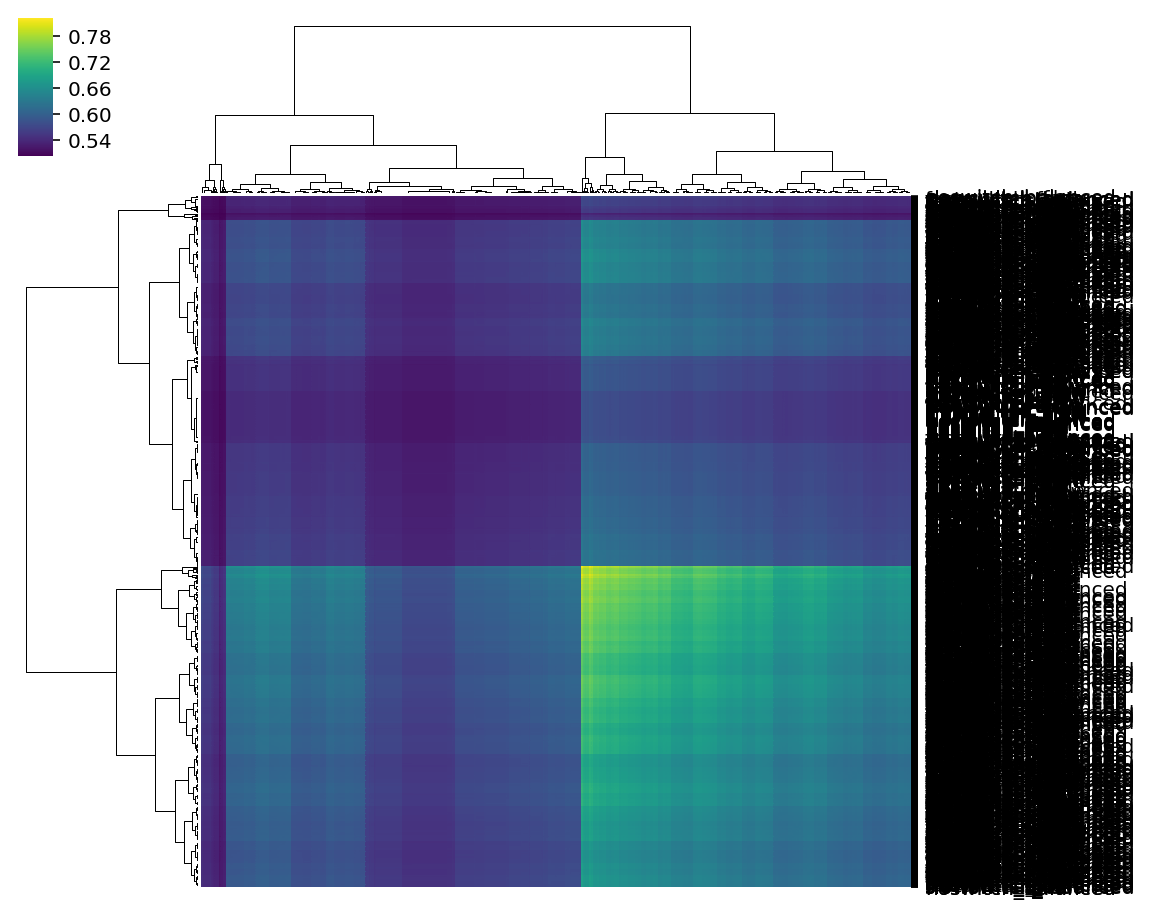

In [32]:
seaborn.clustermap( g, cmap='viridis', method='weighted', metric='euclidean',
                    figsize=(8,8), xticklabels=False, yticklabels=q.label )

Geraph kernels, being based on the tensor product graph, function a bit like
scalar products of graphs. Reasoning by analogy, we can use graph kernels to
construct a distance function.

For a graph kernel $G_k(A,B)$ that yeilds a scalar product of graphs $A$ and $B$,
we would like a function $d_k(A,B)$ that behaves like a distnace function. For vectors,

$ d^2 = \|\vec{B} - \vec{A}\| = (\vec{B}-\vec{A}) \cdot (\vec{B}-\vec{A}) \\
      = \vec{B} \cdot \vec{B} - \vec{B} \cdot \vec{A} - \vec{A} \cdot \vec{B} + \vec{A} \cdot \vec{A} \\
      = \| \vec{B} \|^2 - 2\vec{B} \cdot \vec{A} + \| \vec{A} \|^2 $
      
If $d_k(A,B)$ behaves like $d(\vec{A},\vec{B})$, then :

$d_k(A,B) = G_k(B,B) - 2G_k(B,A) + G_k(A,A)$

Using connected graphlet kernel, this seems to recover the order very well :

In [53]:
d_k = zeros( g.shape )
for i in range( g.shape[0] ) :
    for j in range( g.shape[1] ) :
        d_k[i,j] = sqrt( g[j,j] - 2*g[j,i] + g[i,i] )

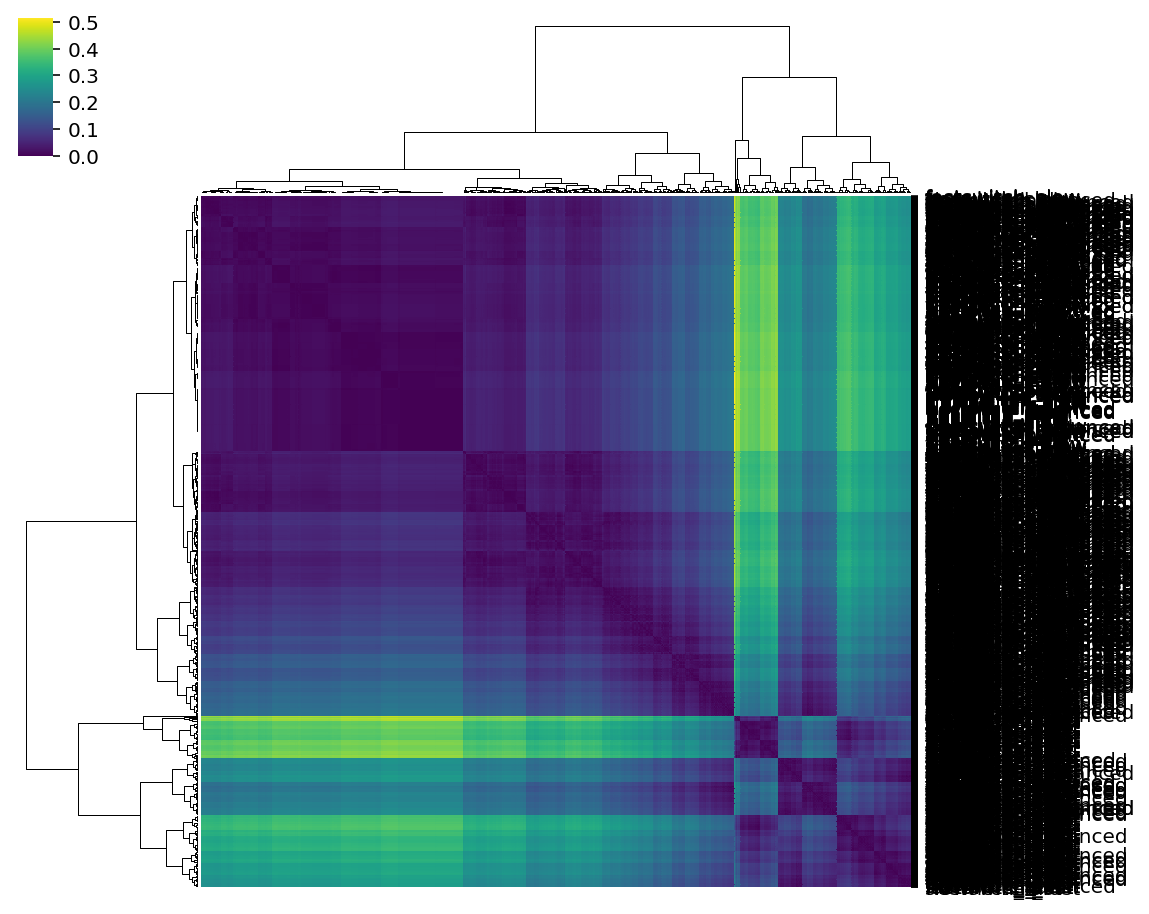

In [54]:
seaborn.clustermap( d_k, cmap='viridis', method='weighted', metric='euclidean',
                    figsize=(8,8), xticklabels=False, yticklabels=q.label )

In [84]:
from sklearn.manifold import TSNE, MDS, Isomap

dk_embedded = pandas.DataFrame( TSNE(n_components=2, perplexity=300).fit_transform( g ),
                                columns=['tSNEx','tSNEy'] )

#dk_embedded = pandas.DataFrame( MDS(n_components=2, metric=True ).fit_transform( g ), 
#                                columns=['MDSx','MDSy'] )

#dk_embedded = pandas.DataFrame( Isomap(n_components=2 ).fit_transform( s_d ), 
#                                columns=['Isox','Isoy'] )

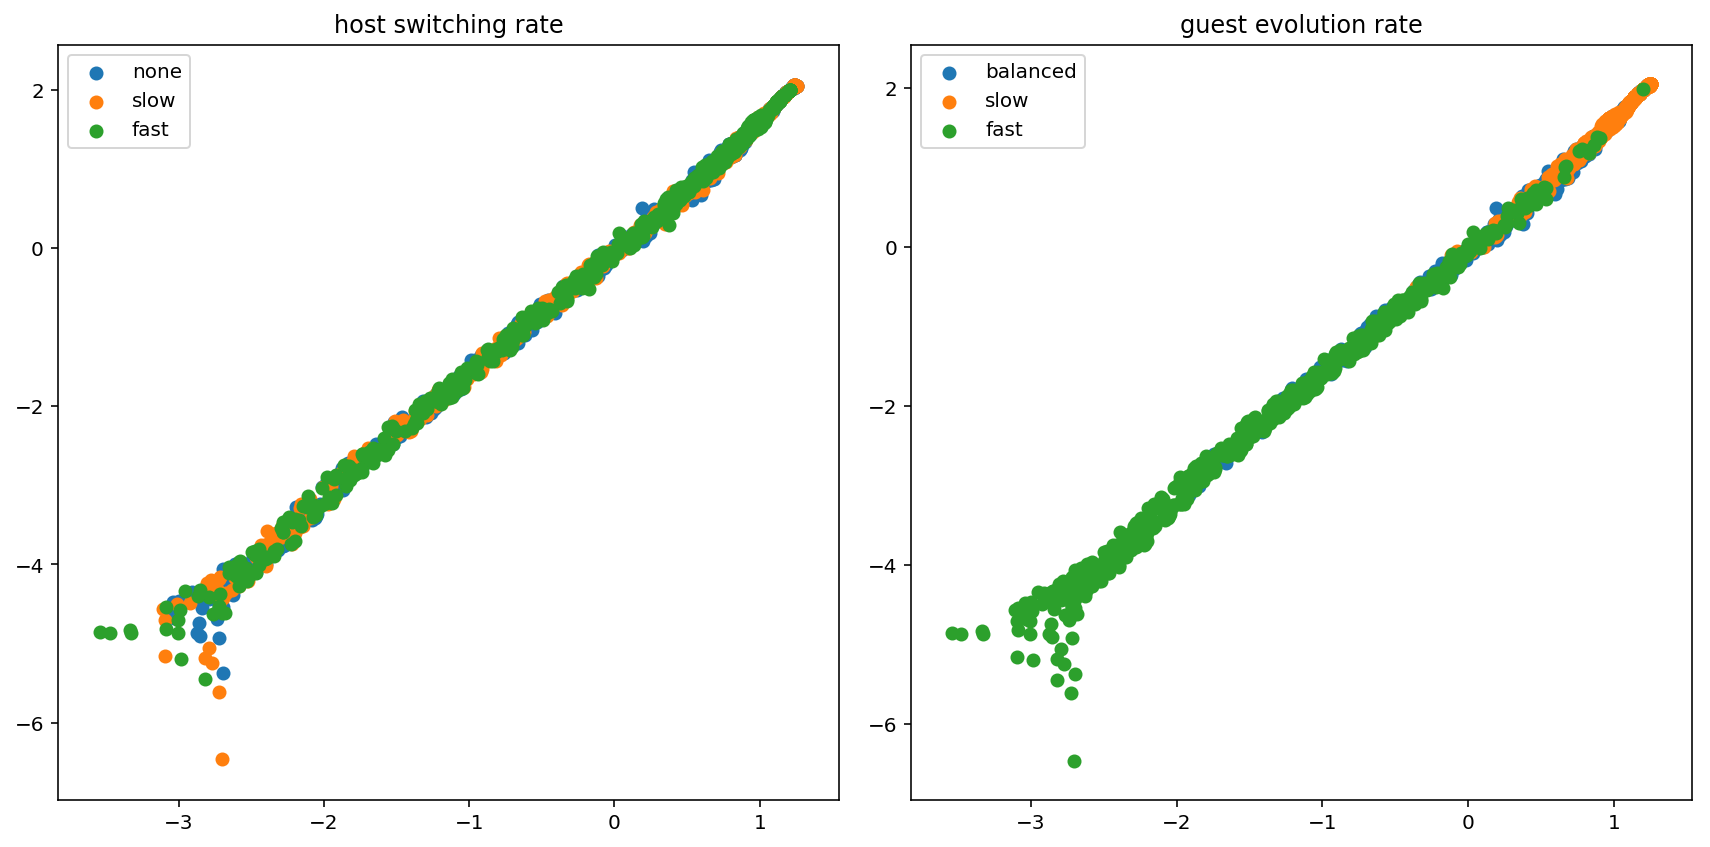

In [82]:
figure( figsize=(12,6) )

qq = q.join( dk_embedded )

xname,yname = dk_embedded.columns

subplot(1,2,1)
title( 'host switching rate' )
for l in set( qq.switch ) :
    scatter( qq[qq.switch==l][xname], qq[qq.switch==l][yname], label=l )
#legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=3, mode="expand", borderaxespad=0. )
legend( loc=2 )

subplot(1,2,2)
title( 'guest evolution rate' )
for l in set( qq.g_evol ) :
    scatter( qq[qq.g_evol==l][xname], qq[qq.g_evol==l][yname], label=l )
#legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=3, mode="expand", borderaxespad=0. )
legend( loc=2 )

tight_layout()

In [51]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import psutil

#X = pandas.get_dummies( q[['g_evol', 'switch']] )
X = pandas.get_dummies( q[['label']] )
#y = pandas.DataFrame( g, index=q.index, columns=q.index )
y = g

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)


#forest = RandomForestClassifier( n_estimators=100,
#                                 criterion='entropy',
#                                 random_state=0,
#                                 n_jobs=4 )

forest = RandomForestRegressor( n_estimators=1000,
                                #criterion='gini',
                                random_state=0,
                                n_jobs=psutil.cpu_count()-2 )


forest.fit( X_train, y_train )
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print( 'Feature ranking :' )
for f in range(X.shape[1]):
    print( '%d. feature %d : %f (%s)' % ( f + 1,
                                          indices[f],
                                          importances[indices[f]],
                                          X.columns[indices[f]] ) )
    
print( 'Score : %f' % ( forest.score( X_test, y_test ) ) )

Feature ranking :
1. feature 7 : 0.329794 (label_slowswitch_fast)
2. feature 4 : 0.307309 (label_noswitch_fast)
3. feature 1 : 0.299270 (label_fastswitch_fast)
4. feature 0 : 0.035261 (label_fastswitch_balanced)
5. feature 6 : 0.010218 (label_slowswitch_balanced)
6. feature 3 : 0.010131 (label_noswitch_balanced)
7. feature 2 : 0.003739 (label_fastswitch_slow)
8. feature 8 : 0.002242 (label_slowswitch_slow)
9. feature 5 : 0.002035 (label_noswitch_slow)
Score : 0.692369


Text(0,0.5,u'feature importance')

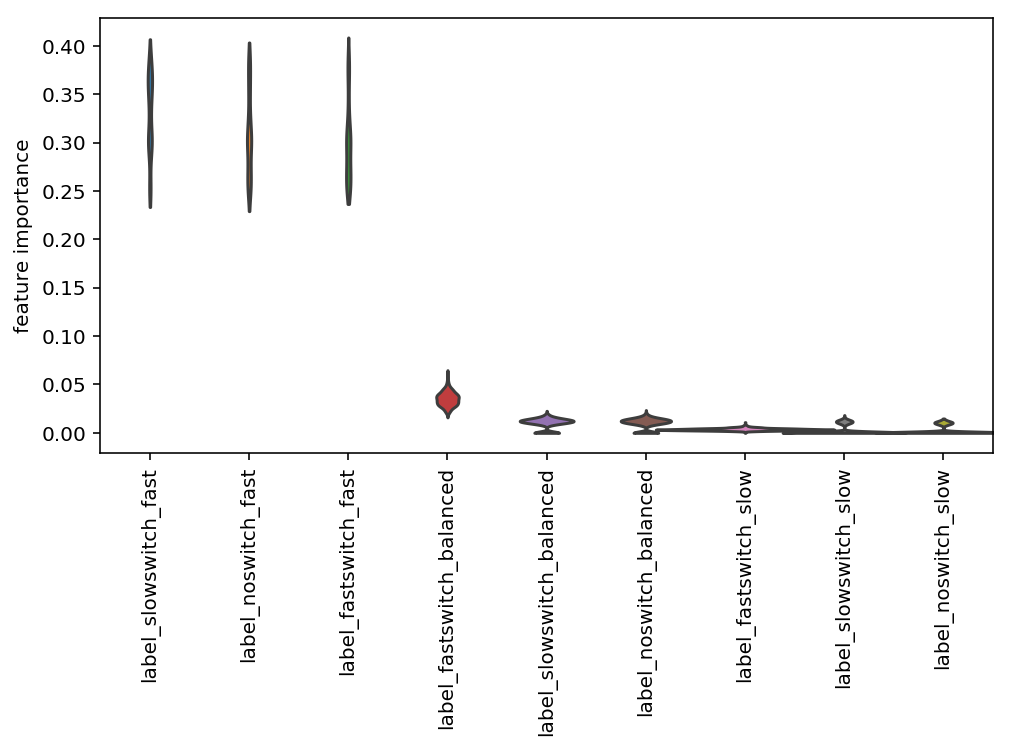

In [38]:
forest_imp = pandas.DataFrame( array( [tree.feature_importances_ for tree in forest.estimators_] ),
                               columns=X.columns)

figure( figsize=(8,4) )
seaborn.violinplot( x='variable',
                    y='value',
                    data=forest_imp.melt(),
                    order=X.columns[indices],
                    width=1.8, cut=0.001, inner=None )
xticks(range(X.shape[1]), rotation='vertical')
xlabel('')
ylabel('feature importance')

## Extended space of graph moments and graph kernels

In [43]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#y = pandas.DataFrame( g, index=q.index, columns=q.index )
y = gm.join( pandas.DataFrame( g ) ).dropna()

#X = pandas.get_dummies( q.loc[ y.index ][['g_evol', 'switch']] )
X = pandas.get_dummies( q.loc[ y.index ][['label']] )

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0 )


#forest = RandomForestClassifier( n_estimators=100,
#                                 criterion='entropy',
#                                 random_state=0,
#                                 n_jobs=4 )

forest = RandomForestRegressor( n_estimators=200,
                                #criterion='gini',
                                random_state=0,
                                n_jobs=4 )


forest.fit( X_train, y_train )
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print( 'Feature ranking :' )
for f in range(X.shape[1]):
    print( '%d. feature %d : %f (%s)' % ( f + 1,
                                          indices[f],
                                          importances[indices[f]],
                                          X.columns[indices[f]] ) )
    
print( 'Score : %f' % ( forest.score( X_test, y_test ) ) )

Feature ranking :
1. feature 1 : 0.322839 (label_fastswitch_fast)
2. feature 4 : 0.316167 (label_noswitch_fast)
3. feature 7 : 0.312930 (label_slowswitch_fast)
4. feature 0 : 0.030798 (label_fastswitch_balanced)
5. feature 8 : 0.005550 (label_slowswitch_slow)
6. feature 5 : 0.005483 (label_noswitch_slow)
7. feature 2 : 0.002565 (label_fastswitch_slow)
8. feature 6 : 0.002191 (label_slowswitch_balanced)
9. feature 3 : 0.001478 (label_noswitch_balanced)
Score : 0.404744


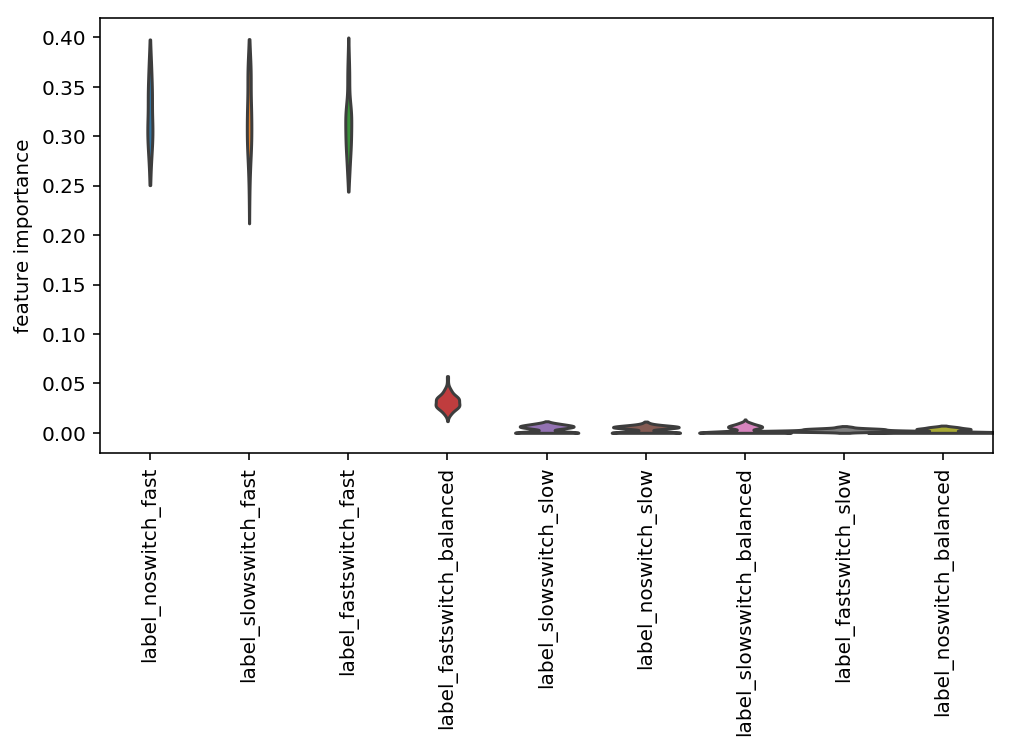

In [420]:
forest_imp = pandas.DataFrame( array( [tree.feature_importances_ for tree in forest.estimators_] ),
                               columns=X.columns)

figure( figsize=(8,4) )
seaborn.violinplot( x='variable',
                    y='value',
                    data=forest_imp.melt(),
                    order=X.columns[indices],
                    width=1.8, cut=0.001, inner=None )
xticks(range(X.shape[1]), rotation='vertical')
xlabel('')
ylabel('feature importance')

In [63]:
from sklearn import metrics


#metrics.classification_report( y_test, forest.predict(X_test) )
print metrics.regression.explained_variance_score( y_test, forest.predict(X_test) )
forest.get_params()

0.6972806215165747


{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': 38,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [67]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV( estimator = forest,
                                param_distributions = random_grid,
                                n_iter = 100,
                                cv = 3,
                                verbose=2,
                                random_state=42,
                                n_jobs = -1)
# Fit the random search model
rf_random.fit( X_train, y_train )

{'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=400, min_samples_split=5, max_features=sqrt, max_depth=30 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=400, min_samples_split=5, max_features=sqrt, max_depth=30 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=400, min_samples_split=5, max_features=sqrt, max_depth=30 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=2000, min_samples_split=5, max_features=sqrt, max_depth=10 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=2000, min_samples_split=5, max_features=sqrt, max_depth=10 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=2000, min_samples_split=5, max_features=sqrt, ma

[CV]  bootstrap=False, min_samples_leaf=2, n_estimators=1000, min_samples_split=5, max_features=sqrt, max_depth=100, total= 1.0min
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=1000, min_samples_split=2, max_features=sqrt, max_depth=20 
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=1800, min_samples_split=10, max_features=auto, max_depth=110 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=800, min_samples_split=5, max_features=sqrt, max_depth=90, total= 1.1min
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=1800, min_samples_split=10, max_features=auto, max_depth=110 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=1000, min_samples_split=2, max_features=auto, max_depth=50, total= 1.3min
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=1800, min_samples_split=10, max_features=auto, max_depth=110 
[CV]  bootstrap=False, min_samples_leaf=2, n_estimators=1000, min_samples_split=5, max_features=sqrt, max_depth=100, total= 1.3min
[CV] bootstrap

[CV]  bootstrap=False, min_samples_leaf=2, n_estimators=1600, min_samples_split=5, max_features=sqrt, max_depth=10, total= 2.8min
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=1200, min_samples_split=2, max_features=sqrt, max_depth=20 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=2000, min_samples_split=5, max_features=sqrt, max_depth=10, total= 2.7min
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=1200, min_samples_split=2, max_features=sqrt, max_depth=20 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=1800, min_samples_split=5, max_features=auto, max_depth=10, total= 2.8min
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=1200, min_samples_split=2, max_features=sqrt, max_depth=20 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=2000, min_samples_split=10, max_features=sqrt, max_depth=10, total= 3.0min
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=1200, min_samples_split=10, max_features=sqrt, max_depth=20 
[CV]  bootstrap=False,

[CV] bootstrap=True, min_samples_leaf=4, n_estimators=200, min_samples_split=5, max_features=auto, max_depth=10 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=800, min_samples_split=5, max_features=sqrt, max_depth=100, total= 1.3min
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=200, min_samples_split=5, max_features=auto, max_depth=10 


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.9min


[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=1400, min_samples_split=5, max_features=sqrt, max_depth=80, total= 2.1min
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=200, min_samples_split=5, max_features=auto, max_depth=10 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=800, min_samples_split=5, max_features=sqrt, max_depth=100, total= 1.4min
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=600, min_samples_split=10, max_features=sqrt, max_depth=60 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=1200, min_samples_split=10, max_features=sqrt, max_depth=20, total= 1.8min
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=600, min_samples_split=10, max_features=sqrt, max_depth=60 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=1200, min_samples_split=2, max_features=sqrt, max_depth=20, total= 2.0min
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=800, min_samples_split=5, max_features=sqrt, max_depth=100, total= 1.5min
[CV] boot

[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=800, min_samples_split=5, max_features=auto, max_depth=None, total= 1.1min
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=1000, min_samples_split=10, max_features=auto, max_depth=50 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=600, min_samples_split=10, max_features=sqrt, max_depth=60, total=  51.6s
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=1000, min_samples_split=10, max_features=auto, max_depth=50 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=1200, min_samples_split=5, max_features=sqrt, max_depth=20, total= 1.4min
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=1000, min_samples_split=10, max_features=auto, max_depth=50 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=800, min_samples_split=5, max_features=auto, max_depth=None, total= 1.1min
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=1000, min_samples_split=5, max_features=auto, max_depth=30 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=1000, min_samples_split=10, max_features=auto, max_depth=50, total= 1.0min
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=1200, min_samples_split=10, max_features=auto, max_depth=None 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=200, min_samples_split=2, max_features=sqrt, max_depth=50, total=  25.8s
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=1200, min_samples_split=10, max_features=auto, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=600, min_samples_split=2, max_features=sqrt, max_depth=60, total=  52.5s
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=1600, min_samples_split=10, max_features=sqrt, max_depth=20 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=1000, min_samples_split=10, max_features=auto, max_depth=50, total= 1.2min
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=1600, min_samples_split=10, max_features=sqrt, max_depth=20 
[CV]  bootstrap

[CV] bootstrap=True, min_samples_leaf=1, n_estimators=1600, min_samples_split=5, max_features=auto, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=1400, min_samples_split=2, max_features=auto, max_depth=100, total= 2.2min
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=1600, min_samples_split=5, max_features=auto, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=1400, min_samples_split=10, max_features=sqrt, max_depth=80, total= 2.3min
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=400, min_samples_split=10, max_features=sqrt, max_depth=90 
[CV]  bootstrap=False, min_samples_leaf=2, n_estimators=1200, min_samples_split=10, max_features=auto, max_depth=None, total= 2.2min
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=400, min_samples_split=10, max_features=sqrt, max_depth=90 
[CV]  bootstrap=False, min_samples_leaf=2, n_estimators=1200, min_samples_split=10, max_features=auto, max_depth=None, total= 2.2min
[CV] bootstrap=F

[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=1800, min_samples_split=2, max_features=auto, max_depth=10, total= 2.9min
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=600, min_samples_split=10, max_features=sqrt, max_depth=40 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=1400, min_samples_split=2, max_features=sqrt, max_depth=80, total= 2.0min
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=400, min_samples_split=5, max_features=sqrt, max_depth=100 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=1400, min_samples_split=2, max_features=sqrt, max_depth=80, total= 2.1min
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=400, min_samples_split=5, max_features=sqrt, max_depth=100 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=1800, min_samples_split=2, max_features=auto, max_depth=10, total= 3.2min
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=600, min_samples_split=10, max_features=auto, max_depth=100, total=  40.6s
[CV] bo

[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=1600, min_samples_split=10, max_features=sqrt, max_depth=None, total= 2.5min
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=1000, min_samples_split=2, max_features=auto, max_depth=10 
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=200, min_samples_split=5, max_features=auto, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=1800, min_samples_split=5, max_features=sqrt, max_depth=60, total= 2.7min
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=1000, min_samples_split=5, max_features=sqrt, max_depth=10, total= 1.8min
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=200, min_samples_split=5, max_features=auto, max_depth=100 
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=200, min_samples_split=5, max_features=auto, max_depth=100 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=1800, min_samples_split=5, max_features=sqrt, max_depth=60, total= 2.9min
[CV] bootstrap=True, 

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 16.5min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=38,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [70]:
rf_random.best_estimator_.score( X_test, y_test )

0.6922409937059673

In [73]:
from sklearn import linear_model

reg = linear_model.Ridge (alpha = .5)
reg.fit( X_train, y_train )
print( 'Score : %f' % reg.score( X_test, y_test ) )

Score : 0.692443


In [79]:
from sklearn import linear_model

reg = linear_model.BayesianRidge()
reg.fit( X_train, y_train )
print( 'Score : %f' % reg.score( X_test, y_test ) )

ValueError: bad input shape (1440, 1800)